In [88]:
import nighres
import numpy
import math
import nibabel
from PIL import Image
from nighres.io import load_volume, save_volume
import scipy.ndimage
from scipy.signal import convolve2d
import os
from nibabel import processing
import subprocess
import shutil
import pandas as pd
import sys
from matplotlib import pyplot as plt
%matplotlib inline

In [96]:


# _df = pd.read_csv('/data/data_drive/Macaque_CB/processing/results_from_cell_counts/all_TP_image_idxs_file_lookup.csv')

# missing_idxs_to_fill = [4]
# # missing_idxs_to_fill = [3]
# # missing_idxs_to_fill = None
# all_image_fnames = list(_df['file_name'].values)

# pre_img = '/data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0055__Image_42_-_20x_cellCount_29_downsample_10p002um_pix.nii.gz'

pre_img = '/data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0055__Image_42_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz'
current_img = '/data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0056_slide_43_Image_01_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz'

# post_img = '/data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0057__Image_43_-_20x_cellCount_29_downsample_10p002um_pix.nii.gz'
post_img = '/data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0057__Image_43_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz'

In [ ]:
def do_reg(sources,targets,run_rigid=True,run_syn=False,file_name='XXX', output_dir ='./'):
    reg = nighres.registration.embedded_antspy_2d_multi(source_images=sources, 
                    target_images=targets,
                    run_rigid=run_rigid,
                    run_affine=False,
                    run_syn=run_syn,
                    scaling_factor=64,
                    cost_function='MutualInformation',
                    interpolation='Linear',
                    regularization='High',
                    convergence=1e-6,
                    mask_zero=False,
                    ignore_affine=False, ignore_orient=False, ignore_res=False,
                    save_data=True, overwrite=True,
                    file_name=file_name, output_dir=output_dir)
    return reg

def compute_intermediate_slice(pre_img,post_img,current_img=None,reg_refinement_iterations=10, idx=None):

    pre_post = do_reg([pre_img],[post_img],file_name='pre_post')
    post_pre = do_reg([post_img],[pre_img],file_name='post_pre')

    reg_pre = pre_post['transformed_source']
    reg_post = post_pre['transformed_source']

    #compute the average in each of the slice spaces, assume in same space!
    img = load_volume(reg_pre)
    avg_post = (img.get_fdata() + load_volume(post_img).get_fdata()) / 2
    # avg_post = nibabel.Nifti1Image(avg_post, img.affine, img.header, dtype=img.get_data_dtype())
    # avg_post_fname = './avg_post.nii.gz'
    # save_volume(avg_post_fname, avg_post,overwrite_file=True)

    img = load_volume(reg_post)
    avg_pre = (img.get_fdata() + load_volume(pre_img).get_fdata()) / 2

    avg = (avg_pre + avg_post)/2
    avg = nibabel.Nifti1Image(avg, img.affine, img.header, dtype=img.get_data_dtype())

    avg_fname = './avg.nii.gz'
    save_volume(avg_fname, avg ,overwrite_file=True)

    # avg_pre = nibabel.Nifti1Image(avg_pre, img.affine, img.header, dtype=img.get_data_dtype())
    # avg_pre_fname = './avg_pre.nii.gz'
    # save_volume(avg_pre_fname, avg_pre,overwrite_file=True)

    for refinement_iter in range(reg_refinement_iterations):
        #now register to the avg, conceptually in the middle of the two images
        pre_avg = do_reg([pre_img],[avg],file_name='pre_avg',run_syn=True)
        post_avg = do_reg([post_img],[avg],file_name='post_avg',run_syn=True)

        img1 = load_volume(pre_avg['transformed_source'])
        img2 = load_volume(post_avg['transformed_source'])

        avg = (img1.get_fdata() + img2.get_fdata()) / 2
        avg = nibabel.Nifti1Image(avg, img1.affine, img1.header, dtype=img1.get_data_dtype())
        save_volume(avg_fname, avg, overwrite_file=True)
    
    if current_img is not None:
        current_avg = load_volume(do_reg([current_img],[avg],file_name='current_avg',run_syn=True)['transformed_source'])
    else:
        current_avg = avg

    if idx is not None:
        return idx, current_avg.get_fdata()
    else:
        return current_avg.get_fdata()    
    
# avg = nibabel.Nifti1Image(avg, img.affine, img.header, dtype=img.get_data_dtype())


In [124]:
pre_img = '/data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0055__Image_42_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz'
current_img = '/data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0056_slide_43_Image_01_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz'

# post_img = '/data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0057__Image_43_-_20x_cellCount_29_downsample_10p002um_pix.nii.gz'
post_img = '/data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0057__Image_43_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz'

res_slice = compute_intermediate_slice(pre_img,post_img,current_img=current_img,reg_refinement_iterations=10)


Embedded ANTs Registration 2D Multi-contrasts

Outputs will be saved to ./

Saving ./pre_post_tmp_srccoordX.nii.gz

Saving ./pre_post_tmp_srccoordY.nii.gz

Saving ./pre_post_tmp_trgcoordX.nii.gz

Saving ./pre_post_tmp_trgcoordY.nii.gz
registering /data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0055__Image_42_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz
 to /data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0057__Image_43_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz
antsRegistration --collapse-output-transforms 1 --dimensionality 2 --initialize-transforms-per-stage 0 --interpolation Linear --output pre_post_tmp_syn --transform Rigid[0.1] --metric MI[/data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0057__Image_43_-_20x_cellCount_29_downsample_10p002um_pix_co

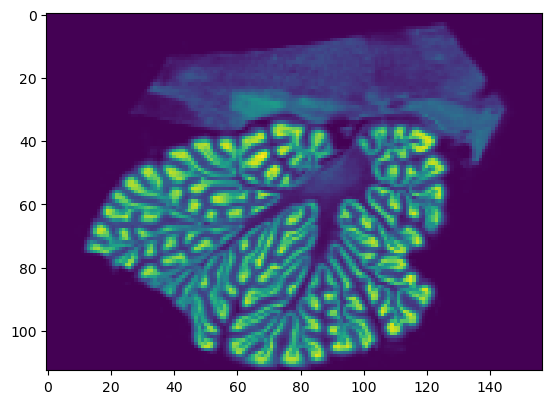

In [89]:

plt.imshow(res_slice)

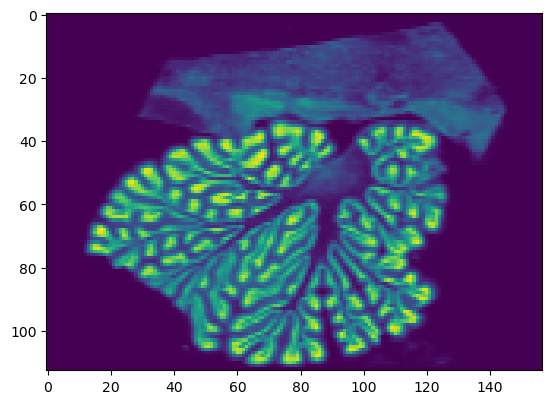

In [100]:
plt.imshow(res_slice)

In [131]:
import os
import nibabel as nib
import tempfile
import shutil

# same, with temporary files
def do_reg(sources, targets, run_rigid=True, run_syn=False, file_name='XXX', output_dir='./',scaling_factor=64):
    # if not type(sources) is list:
    #     sources = [sources]
    # if not type(targets) is list:
    #     targets = [targets]
    reg = nighres.registration.embedded_antspy_2d_multi(
        source_images=sources,
        target_images=targets,
        run_rigid=run_rigid,
        run_affine=False,
        run_syn=run_syn,
        scaling_factor=scaling_factor,
        cost_function='MutualInformation',
        interpolation='Linear',
        regularization='High',
        convergence=1e-6,
        mask_zero=False,
        ignore_affine=False, 
        ignore_orient=False, 
        ignore_res=False,
        save_data=True, 
        overwrite=True,
        file_name=file_name, 
        output_dir=output_dir
    )
    return reg

def compute_intermediate_slice(pre_img, post_img, current_img=None, reg_refinement_iterations=10, idx=None, delete_intermediate_files=True,scaling_factor=64):
    # Create a temporary directory for intermediate files
    temp_dir = tempfile.mkdtemp() if delete_intermediate_files else './'

    try:
        pre_post = do_reg([pre_img], [post_img], file_name='pre_post', output_dir=temp_dir ,scaling_factor=scaling_factor)
        post_pre = do_reg([post_img], [pre_img], file_name='post_pre', output_dir=temp_dir ,scaling_factor=scaling_factor)

        reg_pre = pre_post['transformed_source']
        reg_post = post_pre['transformed_source']

        # Compute averages in slice space
        img = load_volume(reg_pre)
        avg_post = (img.get_fdata() + load_volume(post_img).get_fdata()) / 2

        img = load_volume(reg_post)
        avg_pre = (img.get_fdata() + load_volume(pre_img).get_fdata()) / 2

        avg = (avg_pre + avg_post) / 2
        avg = nib.Nifti1Image(avg, img.affine, img.header, dtype=img.get_data_dtype())

        avg_fname = os.path.join(temp_dir, 'avg.nii.gz')
        save_volume(avg_fname, avg, overwrite_file=True)

        # Refinement loop
        for refinement_iter in range(reg_refinement_iterations):
            print(refinement_iter)
            pre_avg = do_reg([pre_img], [avg_fname], file_name='pre_avg', run_syn=True, output_dir=temp_dir ,scaling_factor=scaling_factor)
            post_avg = do_reg([post_img], [avg_fname], file_name='post_avg', run_syn=True, output_dir=temp_dir ,scaling_factor=scaling_factor)

            img1 = load_volume(pre_avg['transformed_source'])
            img2 = load_volume(post_avg['transformed_source'])

            avg = (img1.get_fdata() + img2.get_fdata()) / 2
            avg = nib.Nifti1Image(avg, img1.affine, img1.header, dtype=img1.get_data_dtype())
            save_volume(avg_fname, avg, overwrite_file=True)

        # If current_img is provided, refine it to match the final average
        if current_img is not None:
            current_avg = load_volume(do_reg([current_img], [avg_fname], file_name='current_avg', run_syn=True, output_dir=temp_dir)['transformed_source'])
        else:
            current_avg = avg

        # Return the result
        if idx is not None:
            return idx, current_avg.get_fdata()
        else:
            return current_avg.get_fdata()

    finally:
        # Cleanup temporary files
        if delete_intermediate_files:
            shutil.rmtree(temp_dir)


In [122]:
res_slice2 = compute_intermediate_slice(pre_img,post_img,current_img=None,reg_refinement_iterations=1)



Embedded ANTs Registration 2D Multi-contrasts

Outputs will be saved to /tmp/tmpls2mrqc3/

Saving /tmp/tmpls2mrqc3/pre_post_tmp_srccoordX.nii.gz

Saving /tmp/tmpls2mrqc3/pre_post_tmp_srccoordY.nii.gz

Saving /tmp/tmpls2mrqc3/pre_post_tmp_trgcoordX.nii.gz

Saving /tmp/tmpls2mrqc3/pre_post_tmp_trgcoordY.nii.gz
registering /tmp/slice_reg_perSliceTemplate_image_weights_dwnsmple_parallel_v2_40_casc_v5_test/zefir_0003__Image_44_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz
 to /tmp/slice_reg_perSliceTemplate_image_weights_dwnsmple_parallel_v2_40_casc_v5_test/zefir_0005__Image_46_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz
antsRegistration --collapse-output-transforms 1 --dimensionality 2 --initialize-transforms-per-stage 0 --interpolation Linear --output pre_post_tmp_syn --transform Rigid[0.1] --metric MI[/tmp/slice_reg_perSliceTemplate_image_weights_dwnsmple_parallel_v2_40_casc_v5_test/zefir_0005__Image_46_-_20x_cellCount_29_downsample_10p002

TypeError: __init__() missing 1 required positional argument: 'cmd'

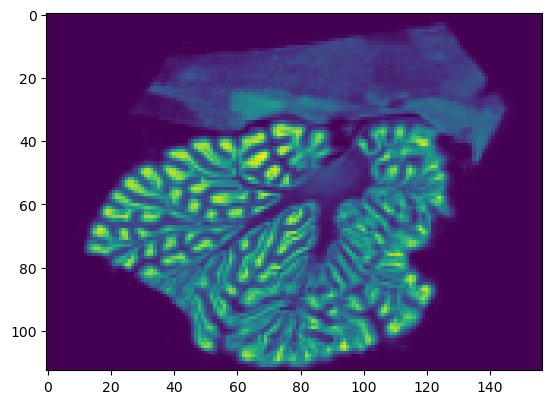

In [108]:
plt.imshow(res_slice2)

In [ ]:
pre_img = '/tmp/slice_reg_perSliceTemplate_image_weights_dwnsmple_parallel_v2_40_casc_v5_test/zefir_0003__Image_44_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz'
post_img = '/tmp/slice_reg_perSliceTemplate_image_weights_dwnsmple_parallel_v2_40_casc_v5_test/zefir_0005__Image_46_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz'
# pre_img = '/data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0055__Image_42_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz'
# post_img = '/data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0057__Image_43_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz'
res_slice2 = compute_intermediate_slice(pre_img,post_img,current_img=None,reg_refinement_iterations=1,scaling_factor=8)


Embedded ANTs Registration 2D Multi-contrasts

Outputs will be saved to ./

Saving ./pre_post_tmp_srccoordX.nii.gz

Saving ./pre_post_tmp_srccoordY.nii.gz

Saving ./pre_post_tmp_trgcoordX.nii.gz

Saving ./pre_post_tmp_trgcoordY.nii.gz
registering /tmp/slice_reg_perSliceTemplate_image_weights_dwnsmple_parallel_v2_40_casc_v5_test/zefir_0003__Image_44_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz
 to /tmp/slice_reg_perSliceTemplate_image_weights_dwnsmple_parallel_v2_40_casc_v5_test/zefir_0005__Image_46_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz
antsRegistration --collapse-output-transforms 1 --dimensionality 2 --initialize-transforms-per-stage 0 --interpolation Linear --output pre_post_tmp_syn --transform Rigid[0.1] --metric MI[/tmp/slice_reg_perSliceTemplate_image_weights_dwnsmple_parallel_v2_40_casc_v5_test/zefir_0005__Image_46_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz, /tmp/slice_reg_perSliceTemplate_image_wei

In [113]:
!antsRegistration --collapse-output-transforms 1 --dimensionality 2 --initialize-transforms-per-stage 0 --interpolation Linear --output pre_avg_tmp_syn --transform Rigid[0.1] --metric MI[./avg.nii.gz, /tmp/slice_reg_perSliceTemplate_image_weights_dwnsmple_parallel_v2_40_casc_v5_test/zefir_0003__Image_44_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz, 1.000, 32, Random, 0.3 ] --convergence [1000x1000x1000x1000x1000x1000x1000, 1e-06, 10 ] --smoothing-sigmas 64x32.0x16.0x8.0x4.0x2.0x1.0 --shrink-factors 64x32x16x8x4x2x1 --use-histogram-matching 0 --winsorize-image-intensities [ 0.001, 0.999 ] --transform SyN[0.2, 4.0, 3.0] --metric MI[./avg.nii.gz, /tmp/slice_reg_perSliceTemplate_image_weights_dwnsmple_parallel_v2_40_casc_v5_test/zefir_0003__Image_44_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz, 1.000, 32, Random, 0.3 ] --convergence [40x40x40x40x50x50x40, 1e-06, 5 ] --smoothing-sigmas 64x32.0x16.0x8.0x4.0x2.0x1.0 --shrink-factors 64x32x16x8x4x2x1 --use-histogram-matching 0 --winsorize-image-intensities [ 0.001, 0.999 ] --write-composite-transform 0